In [41]:
#------ Prologue
import postgkyl as pg
import numpy as np
#import pylab as plt
#import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,4)
import matplotlib.cm as cm
import os, fnmatch, re, sys
import copy
#------ add personnal python utilities
home_dir = os.path.expanduser("~")
sys.path.append(home_dir+'/personal_gkyl_scripts/python_utilities')
from classes import Simulation, Species
from utils import *
#------ Path towards the required folders
expdatadir ='/home/ah1032/amd/g0_sim/diagnostics/gk_tcv/tcv_exp_data/' # a possible directory for exp data
g0simdir   = home_dir+'/g0_sim/'        # This is the main directory of g0 simulations
simname    = '48x32x16x16x6_nunifvg'    # This is the name of the simulation
simdir     = 'gk_tcv_posD_iwl_3x2v_AH/' # This is the simulation directory relative to the g0sim
fileprefix = 'gk_tcv_posD_iwl_3x2v_D02' # This is the prefix before the '-*.gkyl'
# simdir     = 'gk_tcv_NT_iwl_3x2v/' # This is the simulation directory relative to the g0sim
# fileprefix = 'gk_tcv_negD_iwl_3x2v' # This is the prefix before the '-*.gkyl'
wkdir      = 'wk/'                      # This is where the .gkyl files sit relatively to the sim dir
#----- some parameters of the simulation
#----- physical quantities
simulation = Simulation()
simulation.set_phys_param(
    B_axis = 1.4,           # Magnetic field at magnetic axis [T]
    eps0 = 8.854e-12,       # Vacuum permittivity [F/m]
    eV = 1.602e-19,         # Elementary charge [C]
    mp = 1.673e-27,         # Proton mass [kg]
    me = 9.109e-31,         # Electron mass [kg]
)
#----- Geometric equilibrium parameters
simulation.set_geom_param(
    R_axis      = 0.8727315068,         # Magnetic axis major radius
    Z_axis      = 0.1414361745,         # Magnetic axis height
    R_LCFSmid   = 1.0968432365089495,   # Major radius of LCFS at the midplane
    a_shift     = 0.25,                 # Parameter in Shafranov shift
    kappa       = None,                 # Elongation factor
    delta       = None,                 # Triangularity factor
    q0          = None,                 # Safety factor
    x_LCFS      = 0.04                  # position of the LCFS (x_inner)
)

#----- Define the species
ion = Species(name='ion',
              m=2.01410177811*simulation.phys_param.mp, # Ion mass
              q=simulation.phys_param.eV,               # Ion charge [C]
              T0=100*simulation.phys_param.eV, 
              n0=2.0e19)
elc = Species(name='elc',
              m=simulation.phys_param.me, 
              q=-simulation.phys_param.eV, # Electron charge [C]
              T0=100*simulation.phys_param.eV, 
              n0=2.0e19)
simulation.add_species(ion)
simulation.add_species(elc)

# Setup the data parameters, receipe and normalization of the fields
simulation.set_data_param(
    expdatadir = expdatadir, g0simdir = g0simdir, simname = simname, 
    simdir = simdir, fileprefix = fileprefix, wkdir = wkdir, 
    species = simulation.species)

# Load metric coefficients, magnetic field
simulation.geom_param.load_metric(simulation.data_param.fileprefix)

#----- set up the sources
simulation.set_OMPsources(
    n_srcOMP=2.4e23,
    x_srcOMP=0.0,
    Te_srcOMP=2 * simulation.species['elc'].T0,
    Ti_srcOMP=2 * simulation.species['ion'].T0,
    sigma_srcOMP=0.03 * simulation.geom_param.Lx,
    floor_src=1e-2,
)

# Check available frames of the ES potential
tfs = find_available_frames(simulation,'field')
print(tfs)

#---- Set up normalization and units
simulation.normalize('t','mus')
simulation.normalize('x','minor radius')
simulation.normalize('y','Larmor radius')
simulation.normalize('fluid velocities','thermal velocity')
simulation.normalize('temperatures','eV')
simulation.normalize('pressures','beta')
simulation.normalize('energies','MJ')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [42]:
#---- Compute particle loss due to fluctuations over time in the simulation
# (this does not depend on the srcGB parameters)
twindow = tfs
GBloss_i_t, time = simulation.get_GBloss_t(
    spec    = ion,
    twindow = twindow[::4],
    ix      = 0)

GBloss_e_t, time = simulation.get_GBloss_t(
    spec    = elc,
    twindow = twindow[::4],
    ix      = 0)

In [43]:
from classes import GBsource
#---- Evaluate the particle input from the a priori numerical gradB source
simulation.set_GBsource(    
    n_srcGB     = 3.185e23,
    T_srcGB     = 100*simulation.phys_param.eV,
    x_srcGB     = 0,
    sigma_srcGB = 10*simulation.get_rho_s(),
    bfac_srcGB  = 1.4,
    species     = ion,
    temp_model  = 'constant',
    dens_model  = 'singaus',
)
# Store the old version of GBsource which has an a priori amplitude
GBsource_apriori = copy.copy(simulation.GBsource)

# Evaluate the artificial gradB source
[x,y,z] = simulation.geom_param.get_conf_grid()
[X,Y,Z] = custom_meshgrid(x,y,z)
GBs_xyz = GBsource_apriori.dens_source(X,Y,Z)*simulation.geom_param.Jacobian
GBs_tot = integral_xyz(x,y,z,GBs_xyz)
GBsrc_apriori_t = [GBs_tot for t_ in time]


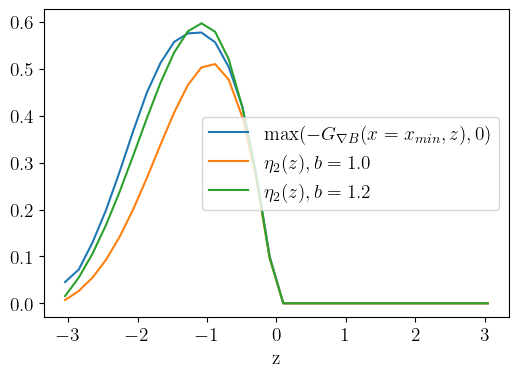

In [44]:
[x,y,z] = simulation.geom_param.get_conf_grid()
eta2 = simulation.GBsource.flux_model(x,y,z,1.0)
eta22 = simulation.GBsource.flux_model(x,y,z,1.2)
simulation.geom_param.compute_bxgradBoB2()
fz = np.maximum(simulation.geom_param.bxgradBoB2[0,0,0,:],0)
plt.plot(z,fz,label=r'$\max(-G_{\nabla B}(x=x_{min},z),0)$')
plt.plot(z,eta2,label=r'$\eta_2(z), b=1.0$')
plt.plot(z,eta22,label=r'$\eta_2(z), b=1.2$')
plt.xlabel('z')
plt.legend();

In [28]:
#---- Create a new gradB source that has an amplitude adapted to the IC
# but still using the flux model
GBsource_adapted = GBsource(    
    n_srcGB     = 3.185e23,
    T_srcGB     = 100*simulation.phys_param.eV,
    x_srcGB     = 0,
    sigma_srcGB = 10*simulation.get_rho_s(),
    bfac_srcGB  = 1.2,
    species     = ion,
    temp_model  = 'constant',
    dens_model  = 'singaus',
)
# we adapt the density rate with simulation data 
GBsource_adapted.adapt_nrate(simulation)
# We now compute the effective gradB source with adaptation
[x,y,z] = simulation.geom_param.get_conf_grid()
[X,Y,Z] = custom_meshgrid(x,y,z)
GBs_xyz = GBsource_adapted.dens_source(X,Y,Z)*simulation.geom_param.Jacobian
GBs_tot = integral_xyz(x,y,z,GBs_xyz)
GBsrc_adapted_t = [GBs_tot for t_ in time]

In [29]:
#---- Create a new gradB source that has an amplitude adapted to the IC
# with the numerical flux computation (true second envelope)
# we do it for ions here
GBsource_truef = GBsource(    
    n_srcGB     = 3.185e23,
    T_srcGB     = 100*simulation.phys_param.eV,
    x_srcGB     = 0,
    sigma_srcGB = 10*simulation.get_rho_s(),
    bfac_srcGB  = 1.4,
    species     = ion,
    temp_model  = 'constant',
    dens_model  = 'trugaus',
    flux        = np.maximum(simulation.geom_param.bxgradBoB2[0, :, :, :],0)
)
# we adapt the density rate with simulation data 
GBsource_truef.adapt_nrate(simulation)
# We now compute the effective gradB source with adaptation
[x,y,z] = simulation.geom_param.get_conf_grid()
[X,Y,Z] = custom_meshgrid(x,y,z)
GBs_xyz = GBsource_truef.dens_source(X,Y,Z)*simulation.geom_param.Jacobian
GBs_tot = integral_xyz(x,y,z,GBs_xyz)
GBsrc_truef_t = [GBs_tot for t_ in time]

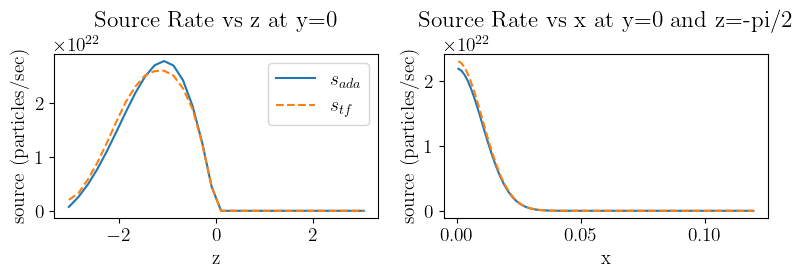

In [30]:
GBsource_apriori_xyz = GBsource_apriori.dens_source(x=X,y=Y,z=Z)
GBsource_adapted_xyz = GBsource_adapted.dens_source(x=X,y=Y,z=Z)
GBsource_truef_xyz   = GBsource_truef.dens_source(x=X,y=Y,z=Z)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

# First subplot: plot along z-direction at y=0
line2, = axs[0].plot(z, GBsource_adapted_xyz[0, 0, :], label=r'$s_{ada}$')
line3, = axs[0].plot(z, GBsource_truef_xyz[0, 0, :],'--', label=r'$s_{tf}$')
axs[0].set_xlabel('z')
axs[0].set_ylabel('source (particles/sec)')
axs[0].set_title('Source Rate vs z at y=0')
axs[0].legend()

# Second subplot: plot along x-direction at y=0 and z=-pi/2
z_idx = np.argmin(np.abs(z + np.pi/2))  # Find index closest to z=-π/2
axs[1].plot(x, GBsource_adapted_xyz[:, 0, z_idx])
axs[1].plot(x, GBsource_truef_xyz[:, 0, z_idx],'--')
axs[1].set_xlabel('x')
axs[1].set_ylabel('source (particles/sec)')
axs[1].set_title('Source Rate vs x at y=0 and z=-pi/2')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

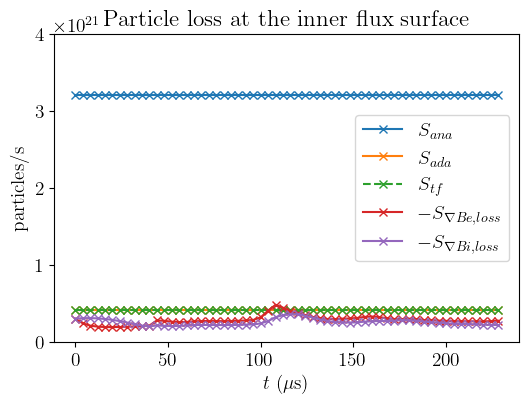

In [31]:
#--- Compare the source and loss along time
plt.plot(time,GBsrc_apriori_t,label=r'$S_{ana}$',linestyle='-',marker='x')
plt.plot(time,GBsrc_adapted_t,label=r'$S_{ada}$',linestyle='-',marker='x')
plt.plot(time,GBsrc_truef_t,label=r'$S_{tf}$',linestyle='--',marker='x')
plt.plot(time,[-g for g in GBloss_e_t],label=r'$-S_{\nabla B e, loss}$',marker='x')
plt.plot(time,[-g for g in GBloss_i_t],label=r'$-S_{\nabla B i, loss}$',marker='x')
plt.ylabel(r'particles/s')
plt.xlabel(r'$t$ ($\mu$s)')
plt.title('Particle loss at the inner flux surface')
plt.ylim([0,4e21])
plt.legend()
plt.show()

In [32]:
print(GBsource_apriori.nrate)
print(GBsource_adapted.nrate)
print(GBsource_truef.nrate)
print(GBsource_apriori.nrate/GBsource_adapted.nrate)

3.185e+23
4.674062265975641e+22
4.523136427099487e+22
6.814201049876641


In [ ]:
import numpy as np

spec = simulation.species['ion']

#------------
#------------
# Method 1: OMP Sources Analysis
def density_srcOMP(ctx, x):
    n_srcOMP = ctx['n_srcOMP']
    x_srcOMP = ctx['x_srcOMP']
    sigma_srcOMP = ctx['sigma_srcOMP']
    floor_src = ctx['floor_src']
    fout = n_srcOMP * (np.exp(-((x - x_srcOMP) ** 2) / (2.0 * sigma_srcOMP ** 2)) + floor_src)
    return fout

def temp_elc_srcOMP(ctx, x):
    x_srcOMP = ctx['x_srcOMP']
    sigma_srcOMP = ctx['sigma_srcOMP']
    Te_srcOMP = ctx['Te_srcOMP']
    mask = x < (x_srcOMP + 3 * sigma_srcOMP)
    fout = np.empty_like(x)
    fout[mask] = Te_srcOMP
    fout[~mask] = Te_srcOMP * 3.0 / 8.0
    return fout

def temp_ion_srcOMP(ctx, x):
    x_srcOMP = ctx['x_srcOMP']
    sigma_srcOMP = ctx['sigma_srcOMP']
    Ti_srcOMP = ctx['Ti_srcOMP']
    mask = x < (x_srcOMP + 3 * sigma_srcOMP)
    fout = np.empty_like(x)
    fout[mask] = Ti_srcOMP
    fout[~mask] = Ti_srcOMP * 3.0 / 8.0
    return fout

# Context dictionary for OMP method
Lx = 0.12
x_min = 0.0
eV = 1.602e-19 
Te0 = 100 * eV
Ti0 = 100 * eV
ctx = {
    'n_srcOMP': 2.4e23,
    'x_srcOMP': x_min,  
    'Te_srcOMP': 2 * Te0,
    'Ti_srcOMP': 2 * Ti0,
    'sigma_srcOMP': 0.03 * Lx,
    'floor_src': 1e-2
}

[x, y, z] = simulation.geom_param.get_conf_grid()
[X, Y, Z] = custom_meshgrid(x, y, z)

# Calculate source terms
srcOMP_elc = density_srcOMP(ctx, X) * 3/2 * temp_elc_srcOMP(ctx, X)
srcOMP_ion = density_srcOMP(ctx, X) * 3/2 * temp_ion_srcOMP(ctx, X)

# Integrate source terms
src_tot_elc = integral_xyz(x, y, z, srcOMP_elc * simulation.geom_param.Jacobian)
src_tot_ion = integral_xyz(x, y, z, srcOMP_ion * simulation.geom_param.Jacobian)

#------------
#------------
# Method 2: BiMaxwellian Sources Analysis
fname = simulation.data_param.fileprefix + '-' + spec.name + '_source_BiMaxwellianMoments_0.gkyl'
fields = {}
fieldnames = ['n', 'upar', 'Tpar', 'Tperp']
for i_, fieldname in enumerate(fieldnames):
    Gdata = pg.data.GData(fname)
    dg = pg.data.GInterpModal(Gdata, 1, 'ms')
    dg.interpolate(i_, overwrite=True)
    fields[fieldname] = np.squeeze(Gdata.get_values())

fields['T'] = (fields['Tpar'] + 2 * fields['Tperp']) / 3
integrant = 3/2 * fields['T'] * fields['n'] * spec.m
BMsrc_tot = integral_xyz(x, y, z, integrant * simulation.geom_param.Jacobian ** 2)

#------------
#------------
# Method 3: M2 Sources Analysis
fname = simulation.data_param.fileprefix + '-' + spec.name + '_source_M2_0.gkyl'
Gdata = pg.data.GData(fname)
dg = pg.data.GInterpModal(Gdata, 1, 'ms')
dg.interpolate(0, overwrite=True)
field = np.squeeze(Gdata.get_values())

integrant = 0.5 * spec.m * field
Msrc_tot = integral_xyz(x, y, z, integrant * simulation.geom_param.Jacobian)

#------------
#------------
# Comparison of results with descriptions
print("\nSummary of Power Input from Different Methods (in MW):")

# Method 1 - OMP Electron and Ion Source
print("Method 1 - OMP Sources:")
print("  This method uses analytical profiles of the input.c file for density and temperature (electron and ion) sources.")
print(f"  Electron Power Input: {src_tot_elc / 1e6:.6f} MW")
print(f"  Ion Power Input: {src_tot_ion / 1e6:.6f} MW\n")

# Method 2 - BiMaxwellian Source
print("Method 2 - BiMaxwellian Source:")
print("  This method uses the BiMaxwellian moments (n, Tpar, Tperp) from Gkeyll source output files.")
print(f"  %s Power Input: {BMsrc_tot / 1e6:.6f} MW\n"%(spec.name))

# Method 3 - M2 Source
print("Method 3 - M2 Source:")
print("  This method computes power input using the second moment of the velocity distribution (M2) from Gkeyll source output file.")
print(f"  %s Power Input : {Msrc_tot / 1e6:.6f} MW\n"%(spec.name))

In [ ]:
#--- Check integrated moments
fname = simulation.data_param.fileprefix + '-elc_integrated_moms.gkyl'
Gdata = pg.data.GData(fname)
# dg = pg.data.GInterpModal(Gdata,1,'ms')
# dg.interpolate(0,overwrite=True)
F  = Gdata.get_values()
plt.plot(F[:,3]*simulation.species['elc'].m)